### Break-up each sequence into overlapping subsequences of fixed length (e.g size=20, step=10). 

In [1]:
import os
import json
from glob import glob
import numpy as np
from numpy import array
from numpy import argmax
from numpy import newaxis
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate, Activation, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [3]:
def get_compiled_data(path):
    f_path = path
    f_list = sorted(glob(os.path.join(f_path, "*.json")))

    f_compile =[]

    for j in f_list: 
        file = open(j, "r")
        content = file.read()
        data = json.loads(content)
        f_compile.append(data)
    return f_compile

In [4]:
X_original = get_compiled_data(path="/content/drive/MyDrive/dataset-460-40/x")

In [5]:
y_original = get_compiled_data(path="/content/drive/MyDrive/dataset-460-40/y")

In [6]:
step = 10
size = 10
X = []
y = []

for i in range(len(y_original)):
  row = y_original[i]

  for idx in range(0, len(row), step):
      if len(row[idx:idx + size]) == size:
        y.append(row[idx:idx + size])

  row = X_original[i]

  for idx in range(0, len(row), step):
    if len(row[idx:idx + size]) == size:
      X.append(row[idx:idx + size]) 

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=1)

In [8]:
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

3662 3662 407 407


Data Augmentation for X_train and y_train

In [9]:
#Data Augmentation (translation by 5 units up and right)
#X_train_trans_aug = [[[v+5 for v in inner1] for inner1 in inner] for inner in X_train]

In [10]:
#import copy
#y_train_trans_aug = copy.deepcopy(y_train)

In [ ]:
#X_train.extend(X_train_trans_aug)
#y_train.extend(y_train_trans_aug)

In [ ]:
#print(len(X_train), len(y_train))
#No of training sample inc by twice

Remove sequences with values above 499

In [9]:
compiled_x = []
compiled_y = []

for i, seq in enumerate(X_train):
  value_check=[]
  for _, coord in enumerate(seq):
    coord_01 = coord[0]
    coord_02 = coord[1]
    value_check.append(coord_01)
    value_check.append(coord_02)
  if max(value_check) < 500:
    compiled_x.append(seq)
    compiled_y.append(y_train[i])

In [10]:
print(len(compiled_x), len(compiled_y), len(X_valid), len(y_valid))

3662 3662 407 407


In [11]:
#For variable naming standardisation, "rename" X_valid to compiled_x_valid
compiled_x_valid = X_valid
compiled_y_valid = y_valid

# For encoder input (training)

In [12]:
encoder_input = []
for i in range(len(compiled_x)):
  data = compiled_x[i]   
  while len(data) < 10:                        #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append([500,500])                     #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input.append(data)

In [13]:
encoder_input = np.array(encoder_input)
encoder_input.shape

(3662, 10, 2)

One-hot encode encoder input (training)

In [14]:
# Concatenate all coordinates side by side so that [(12,15),(23, 30),(32, 41),...] becomes [12,15,23,30,32,41,...]
X1 = list()
for i in range(encoder_input.shape[0]):
  row=list()
  for j in range(10):                          #Change here accordingly (? cuz there are ? time-step in each sequence)
    row.append(encoder_input[i][j][0])
    row.append(encoder_input[i][j][1])
  X1.append(row)

In [15]:
X1 = np.array(X1)
X1.shape

(3662, 20)

In [16]:
X1 = to_categorical([X1], num_classes=500)      #500 cuz 0-499 for input values, none for padding
X1.shape

(1, 3662, 20, 500)

In [17]:
X1 = X1.reshape(3662, 20, 500)
X1.shape

(3662, 20, 500)

# For encoder input (validation)

In [18]:
encoder_input_valid = []
for i in range(len(compiled_x_valid)):
  data = compiled_x_valid[i]   
  while len(data) < 10:                        #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append([500,500])                     #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input_valid.append(data)

In [19]:
encoder_input_valid = np.array(encoder_input_valid)
encoder_input_valid.shape

(407, 10, 2)

In [20]:
X1_valid = list()
for i in range(encoder_input_valid.shape[0]):
  row=list()
  for j in range(10):                           #Change here accordingly (? cuz there are ? time-step in each sequence)
    row.append(encoder_input_valid[i][j][0])
    row.append(encoder_input_valid[i][j][1])
  X1_valid.append(row)

In [21]:
X1_valid = np.array(X1_valid)
X1_valid.shape

(407, 20)

In [22]:
X1_valid = to_categorical([X1_valid], num_classes=500)
X1_valid.shape

(1, 407, 20, 500)

In [23]:
X1_valid = X1_valid.reshape(407, 20, 500)
X1_valid.shape

(407, 20, 500)

# For decoder_target (training)

In [24]:
Y = []
for i in range(len(compiled_y)):
  data = compiled_y[i]                                   
  while len(data) < 10:                         #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append(0)                              #Make all samples to be of the same sequence length by padding it with "0"
  Y.append(data)

In [25]:
Y = np.array(Y)
Y.shape

(3662, 10)

In [27]:
Y = Y.reshape(3662, 10, 1)                  
Y.shape

(3662, 10, 1)

In [28]:
Y = to_categorical([Y], num_classes=3)
Y.shape

(1, 3662, 10, 3)

In [29]:
Y = Y.reshape(3662, 10, 3)                  
Y.shape

(3662, 10, 3)

# For decoder_target (validation)

In [30]:
Y_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i]                                   
  while len(data) < 10:                        #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append(0)                             #Make all samples to be of the same sequence length by padding it with "0"
  Y_valid.append(data)

In [31]:
Y_valid = np.array(Y_valid)
Y_valid.shape

(407, 10)

In [32]:
Y_valid = Y_valid.reshape(407, 10, 1)
Y_valid.shape

(407, 10, 1)

In [33]:
Y_valid = to_categorical([Y_valid], num_classes=3)
Y_valid.shape

(1, 407, 10, 3)

In [34]:
Y_valid = Y_valid.reshape(407, 10, 3)
Y_valid.shape

(407, 10, 3)

# For decoder input (shifted version of decoder target) - (training)

In [35]:
X2 = []
for i in range(len(compiled_y)):
  data = compiled_y[i] 
  while len(data) < 10:                         #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append(0)                              #Make all samples to be of the same sequence length by padding it with zero
  data = [2] + data[:-1]                        #2 for indicating start of decoder input sequence (requirement for force teaching)
  X2.append(data)

In [36]:
X2 = np.array(X2)
X2.shape

(3662, 10)

In [37]:
X2 = X2.reshape(3662, 10, 1)
X2.shape

(3662, 10, 1)

In [38]:
X2 = to_categorical([X2], num_classes=3)
X2.shape

(1, 3662, 10, 3)

In [39]:
X2 = X2.reshape(3662, 10, 3)
X2.shape

(3662, 10, 3)

# For decoder input (shifted version of decoder target) - (validation)

In [40]:
X2_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i] 
  while len(data) < 10:                        #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append(0)                             #Make all samples to be of the same sequence length by padding it with zero
  data = [2] + data[:-1]                       #2 for indicating start of decoder input sequence (requirement for force teaching)
  X2_valid.append(data)

In [41]:
X2_valid = np.array(X2_valid)
X2_valid.shape

(407, 10)

In [42]:
X2_valid = X2_valid.reshape(407, 10, 1)
X2_valid.shape

(407, 10, 1)

In [43]:
X2_valid = to_categorical([X2_valid], num_classes=3)
X2_valid.shape

(1, 407, 10, 3)

In [44]:
X2_valid = X2_valid.reshape(407, 10, 3)
X2_valid.shape

(407, 10, 3)

# Creation of test samples

In [45]:
X_test_original = get_compiled_data("/content/drive/MyDrive/dataset-460-40/x_test")

In [78]:
y_test_original = get_compiled_data("/content/drive/MyDrive/dataset-460-40/y_test")

In [79]:
step = 10
size = 10
X_test = []
y_test = []

for i in range(len(y_test_original)):
  row = y_test_original[i]

  for idx in range(0, len(row), step):
    if len(row[idx:idx + size]) == size:
      y_test.append(row[idx:idx + size])

  row = X_test_original[i]

  for idx in range(0, len(row), step):
    if len(row[idx:idx + size]) == size:
      X_test.append(row[idx:idx + size]) 

In [48]:
encoder_input_test = []
for i in range(len(X_test)):
  data = X_test[i]   
  while len(data) < 10:                         #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append([500,500])                      #Make all samples to be of the same sequence length by padding it with 500. 
  encoder_input_test.append(data)

In [49]:
encoder_input_test = np.array(encoder_input_test)
encoder_input_test.shape

(360, 10, 2)

In [50]:
X1_test = list()
for i in range(encoder_input_test.shape[0]):
  row=list()
  for j in range(10):                           #Change here accordingly (? cuz there are ? time-step in each sequence)
    row.append(encoder_input_test[i][j][0])
    row.append(encoder_input_test[i][j][1])
  X1_test.append(row)

In [51]:
X1_test = np.array(X1_test)
X1_test.shape

(360, 20)

In [52]:
X1_test = to_categorical([X1_test], num_classes=500)
X1_test.shape

(1, 360, 20, 500)

In [54]:
X1_test = X1_test.reshape(360, 20, 500)
X1_test.shape

(360, 20, 500)

In [55]:
Y_test = []
for i in range(len(y_test)):
  data = y_test[i]                                   
  while len(data) < 10:                          #Change here accordingly (? cuz there are ? time-step in each sequence)
    data.append(0)                               #Make all samples to be of the same sequence length by padding it with "0"
  Y_test.append(data)

In [56]:
Y_test = np.array(Y_test)
Y_test.shape

(360, 10)

In [57]:
Y_test = Y_test.reshape(360, 10, 1)
Y_test.shape

(360, 10, 1)

In [58]:
Y_test = to_categorical([Y_test], num_classes=3)
Y_test.shape

(1, 360, 10, 3)

In [60]:
Y_test = Y_test.reshape(360, 10, 3)
Y_test.shape

(360, 10, 3)

# Start of main program

####Model built witih normal LSTM cell

In [ ]:
# # returns train, inference_encoder and inference_decoder models
# def define_models(n_features_input, n_features_output, n_units):

# 	# define training encoder
# 	encoder_inputs = Input(shape=(None, n_features_input))
# 	encoder = LSTM(n_units, return_state=True)
# 	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# 	encoder_states = [state_h, state_c]

# 	# define training decoder
# 	decoder_inputs = Input(shape=(None, n_features_output))
# 	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
# 	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 	decoder_dense = Dense(n_features_output, activation='softmax')
# 	decoder_outputs = decoder_dense(decoder_outputs)
# 	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
 
# 	# define inference encoder
# 	encoder_model = Model(encoder_inputs, encoder_states)
 
# 	# define inference decoder
# 	decoder_state_input_h = Input(shape=(n_units,))
# 	decoder_state_input_c = Input(shape=(n_units,))
# 	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# 	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 	decoder_states = [state_h, state_c]
# 	decoder_outputs = decoder_dense(decoder_outputs)
# 	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
 
# 	# return all models
# 	return model, encoder_model, decoder_model

###Model built with bidirectional LSTM cell

In [61]:
from keras.layers import Bidirectional, Concatenate

# returns train, inference_encoder and inference_decoder models
def define_models(n_features_input, n_features_output, n_units):

	# define training encoder
	encoder_inputs = Input(shape=(None, n_features_input))
	encoder = Bidirectional(LSTM(n_units, dropout=0.3, return_state=True))        #Bidirectional LSTM
	encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
	state_h = Concatenate()([forward_h, backward_h])
	state_c = Concatenate()([forward_c, backward_c])
	encoder_states = [state_h, state_c]

	# define training decoder
	decoder_inputs = Input(shape=(None, n_features_output))
	decoder_lstm = LSTM(n_units*2, return_sequences=True, return_state=True)      #Multiple by 2 cuz of bidirectional
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_features_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
 
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
 
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units*2,))                             #Multiple by 2 cuz of bidirectional
	decoder_state_input_c = Input(shape=(n_units*2,))                             #Multiple by 2 cuz of bidirectional
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
 
	# return all models
	return model, encoder_model, decoder_model

### Metrics

In [62]:
precision =tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [63]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())    
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    
    return 1 - K.mean(f1)

In [64]:
# configure problem
import tensorflow as tf
n_features_input = 500
n_features_output = 3
n_units = 128

#from keras.callbacks import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.2, patience=15, min_lr=0.001)

# define model
train, infenc, infdec = define_models(n_features_input, n_features_output, n_units)

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode='max', patience = 15, restore_best_weights=True)

train.compile(loss=loss, optimizer=optimizer, metrics=['acc', precision, recall, f1])

# generate training dataset
print(X1.shape,X2.shape,Y.shape)
# train model
history = train.fit([X1, X2], Y, batch_size=32, epochs=200, validation_data=([X1_valid, X2_valid],Y_valid),callbacks=[early_stop])

(3662, 20, 500) (3662, 10, 3) (3662, 10, 3)
Epoch 1/200
115/115 [==============================] - 16s 106ms/step - loss: 0.7319 - acc: 0.5977 - precision: 0.6028 - recall: 0.4838 - f1: 0.2574 - val_loss: 0.6541 - val_acc: 0.6233 - val_precision: 0.6233 - val_recall: 0.6233 - val_f1: 0.3345
Epoch 2/200
115/115 [==============================] - 11s 97ms/step - loss: 0.6517 - acc: 0.6245 - precision: 0.6245 - recall: 0.6245 - f1: 0.3607 - val_loss: 0.6439 - val_acc: 0.6292 - val_precision: 0.6292 - val_recall: 0.6292 - val_f1: 0.3746
Epoch 3/200
115/115 [==============================] - 11s 97ms/step - loss: 0.6456 - acc: 0.6275 - precision: 0.6275 - recall: 0.6274 - f1: 0.3672 - val_loss: 0.6412 - val_acc: 0.6270 - val_precision: 0.6269 - val_recall: 0.6268 - val_f1: 0.3604
Epoch 4/200
115/115 [==============================] - 11s 97ms/step - loss: 0.6470 - acc: 0.6241 - precision: 0.6241 - recall: 0.6239 - f1: 0.3630 - val_loss: 0.6419 - val_acc: 0.6256 - val_precision: 0.6256 - val

In [ ]:
train.summary()

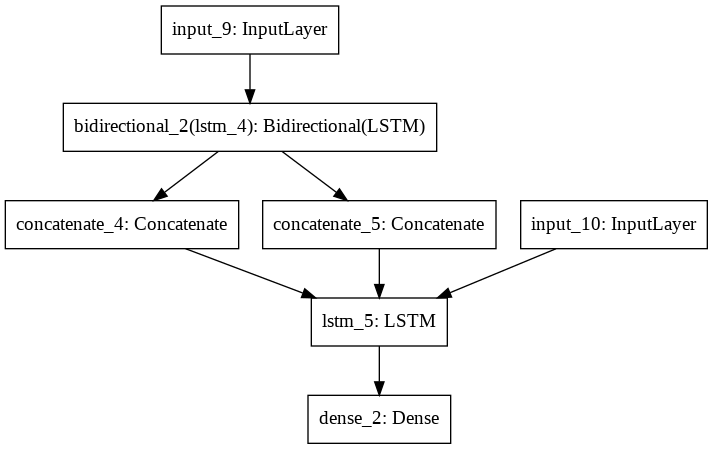

In [65]:
tf.keras.utils.plot_model(train,to_file='/content/model.png')

dict_keys(['loss', 'acc', 'precision', 'recall', 'f1', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'])


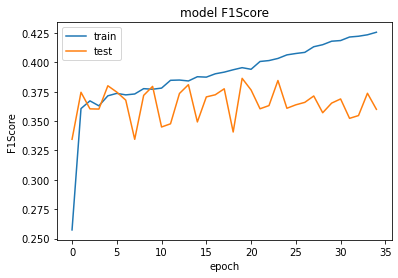

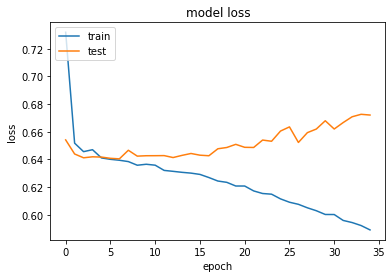

In [65]:
import matplotlib.pyplot as plt 
print(history.history.keys())
# summarize history for F1Score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1Score')
plt.ylabel('F1Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
# generate target given source sequence
def predict_sequence(infenc, infdec, input, n_steps_out, n_features): 
  #n_steps_out->no. of time-step in output
  #n_features->no. of features in output
	# encode
	state = infenc.predict(input)
	# start of sequence input
	target_seq = array([0.0 for _ in range(n_features)]).reshape(1, 1, n_features)
	# collect predictions
	output = list()
	for t in range(n_steps_out):
		# predict next char
		yhat, h, c = infdec.predict([target_seq] + state)
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state = [h, c]
		# update target sequence
		target_seq = yhat
	return array(output)

In [67]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]


# Evaluate with test sample

In [96]:
pred= []
n_features=3
n_steps_out = 10                  #Change here accordingly (? cuz there are ? time-step in each sequence)
for i in range(X1_test.shape[0]):
  test = X1_test[i]
  test = test[newaxis,:, :]
  prediction = predict_sequence(infenc, infdec, test, n_steps_out, n_features)
  prediction = one_hot_decode(prediction)
  pred.extend(prediction)

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [98]:
truth = []
for i in range(len(y_test)):
  data = y_test[i]            
  truth.extend(data)

In [99]:
matrix = confusion_matrix(truth, pred, labels=[0,1])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, pred, labels=[0,1]))

Confusion matrix : 
 [[ 745  839]
 [ 747 1269]]
              precision    recall  f1-score   support

           0       0.50      0.47      0.48      1584
           1       0.60      0.63      0.62      2016

    accuracy                           0.56      3600
   macro avg       0.55      0.55      0.55      3600
weighted avg       0.56      0.56      0.56      3600



#Evaluate with single test sample


In [82]:
test = X1_test[0]
test.shape

(40, 500)

In [83]:
test = test[newaxis,:, :]
test.shape

(1, 40, 500)

In [84]:
n_features=3
n_steps_out = 10        #Change here accordingly (? cuz there are ? time-step in each sequence)
prediction = predict_sequence(infenc, infdec, test, n_steps_out, n_features)


In [85]:
prediction = one_hot_decode(prediction)
prediction = np.array(prediction)

In [86]:
truth = Y_test[0]
truth = one_hot_decode(truth)
truth = np.array(truth)

In [87]:
matrix = confusion_matrix(truth, prediction, labels=[0,1])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1]))

Confusion matrix : 
 [[4 3]
 [7 6]]
              precision    recall  f1-score   support

           0       0.36      0.57      0.44         7
           1       0.67      0.46      0.55        13

    accuracy                           0.50        20
   macro avg       0.52      0.52      0.49        20
weighted avg       0.56      0.50      0.51        20



In [88]:
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))


{0: 11, 1: 9}

In [89]:
unique, counts = np.unique(truth, return_counts=True)
dict(zip(unique, counts))

{0: 7, 1: 13}

In [90]:
prediction

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [91]:
truth

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0])